<a href="https://colab.research.google.com/github/gvigkannan/Awesome-SuperResolution/blob/master/COVID_Prediction_Qatar_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import numpy as np
import time
import os 
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import pandas as pd
import csv
from PIL import Image, ImageOps
import cv2
from collections import OrderedDict

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, torchsummary
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

In [ ]:
## XRay Vision Model
## Downloading Torch XRay vision Models
!pip install torchxrayvision
import torchxrayvision as xrv

     |████████████████████████████████| 25.0MB 74.0MB/s 
     |████████████████████████████████| 1.9MB 54.2MB/s 


## Drive and Random State

In [ ]:
## To access the drive files!
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def set_state(random_seed):
  np.random.seed(random_seed)
  torch.manual_seed(random_seed)
  

## Hyperparam


In [ ]:
## Hyperparams!
STEP_FLAG = False
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.01
RANDOM_STATE = 0
MODEL_NAME = "_".join(("COVID_Fusic_RS"+str(RANDOM_STATE),"E"+str(EPOCHS),"Clf_v1"))
MODEL_PATH = "/content/drive/MyDrive/Models"
set_state(RANDOM_STATE)

In [ ]:
print(MODEL_NAME)

COVID_Fusic_RS0_E25_Clf_v1


In [ ]:
## Loading the dataset
IMG_DIR = "/content/drive/MyDrive/Dataset/COVID_Detection/DATA_300"
# data_fnames = os.listdir(IMG_DIR)
# use_cols = ['Filename', 
#             'BrixiaScoreGlobal']
#             # 'Brixia_RegionA', 
#             # 'Brixia_RegionB', 
#             # 'Brixia_RegionC', 
#             # 'Brixia_RegionD', 
#             # 'Brixia_RegionE', 
#             # 'Brixia_RegionF']
# annot_train = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_train_v1.csv", usecols = use_cols)
# annot_test = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_test_v1.csv", usecols = use_cols)
# annot_val = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_val_v1.csv", usecols = use_cols)

In [ ]:
train_dir = os.path.join(IMG_DIR, "train")
val_dir = os.path.join(IMG_DIR, "val")
test_dir = os.path.join(IMG_DIR, "test")

transforms = T.Compose([T.ToTensor(), T.Resize(size = (224, 224))])
# print(train_dir)
train_data = ImageFolder(root = train_dir, transform = transforms)
train_dl = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = 4)

val_data = ImageFolder(root = val_dir, transform = transforms)
val_dl = DataLoader(val_data, BATCH_SIZE, shuffle = True, num_workers = 4)

test_data = ImageFolder(root = test_dir, transform = transforms)
test_dl = DataLoader(test_data, BATCH_SIZE, shuffle = True, num_workers = 4)

In [ ]:
# img, label = next(iter(val_dl))
# torch.max(img) ## Already normalized!

In [ ]:
img_datasets = {x: datasets.ImageFolder(os.path.join(IMG_DIR, x), transform = transforms) for x in ['train', 'val']}
dataloaders = {x: DataLoader(img_datasets[x], BATCH_SIZE, shuffle = True, num_workers = 4) for x in ['train', 'val']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes

In [ ]:
next(iter(val_dl))

[tensor([[[[2.6904e-02, 2.7451e-02, 2.7451e-02,  ..., 2.4186e-02,
            2.2234e-02, 1.4827e-02],
           [2.4186e-02, 2.7451e-02, 2.7451e-02,  ..., 2.7451e-02,
            2.6479e-02, 2.2219e-02],
           [2.6919e-02, 2.7451e-02, 2.7451e-02,  ..., 2.7451e-02,
            2.7451e-02, 2.0921e-02],
           ...,
           [5.4638e-01, 5.7484e-01, 6.0603e-01,  ..., 5.5780e-01,
            5.2418e-01, 4.9550e-01],
           [5.6403e-01, 5.9414e-01, 6.2259e-01,  ..., 5.7324e-01,
            5.4512e-01, 5.1533e-01],
           [5.8497e-01, 6.1508e-01, 6.4188e-01,  ..., 5.9418e-01,
            5.6768e-01, 5.4390e-01]],
 
          [[2.6904e-02, 2.7451e-02, 2.7451e-02,  ..., 2.4186e-02,
            2.2234e-02, 1.4827e-02],
           [2.4186e-02, 2.7451e-02, 2.7451e-02,  ..., 2.7451e-02,
            2.6479e-02, 2.2219e-02],
           [2.6919e-02, 2.7451e-02, 2.7451e-02,  ..., 2.7451e-02,
            2.7451e-02, 2.0921e-02],
           ...,
           [5.4638e-01, 5.7484e-01, 6.

## Model Related


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_brixia = models.densenet121(pretrained = True)
for param in model_brixia.parameters():
  param.requires_grad = False
model_brixia.op_threshs = None
model_brixia.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
num_ftrs = model_brixia.classifier.in_features

In [ ]:
FFNN = nn.Sequential(
    nn.Linear(in_features = num_ftrs, out_features = 2))
model_brixia.classifier = FFNN.to(device)

In [ ]:
# torchsummary.summary(model_brixia, (3, 224, 224))

In [ ]:
## To do: Training Script!
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, numEpochs):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()

  best_WandB = copy.deepcopy(model.state_dict())
  best_loss = np.inf 
  best_acc = 0.0
  train_histLoss, val_histLoss = {}, {}
  train_histAcc, val_histAcc = {}, {}
  ## For all the epochs:
  for epoch in tqdm(range(numEpochs)):
    epoch_loss = 0.0
    start_epoch = time.time()
    # if epoch % 15 == 0:
    #   print("*"*10)
    #   print("Epoch {}/{}".format(epoch + 1, numEpochs))
    #   print("*"*10)

    ## For each phase: train vs val
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      ## Tracking loss
      running_loss = 0.0
      running_accs = 0

      ## For all phase data:
      for imgs, labels in dataloaders[phase]:
        imgs = tuple(imgs)
        imgs = torch.stack(imgs).to(device)
        labels = labels.to(device)

        ## Zero the gradients
        optimizer.zero_grad()

        # ## Epoch Stats
        # epoch_loss += loss.item()

        ## Forward Prop
        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(imgs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          ## Backward Prop
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_accs += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_accs.double() / dataset_sizes[phase]

      if phase == 'train':
        train_histLoss[epoch] = epoch_loss
        train_histAcc[epoch] = epoch_acc
      else:
        val_histLoss[epoch] = epoch_loss
        val_histAcc[epoch] = epoch_acc

      if epoch % 20 == 0:
        print("{}\tLoss: {:.4f}\tTime: {:.4f}".format(phase, epoch_loss, time.time() - start_epoch))
      ## Check for loss: ## We don't check for validation loss
      ## Need to write a function for rmse 


      if phase == 'val' and best_acc < epoch_acc:
        best_loss = epoch_loss
        best_acc = epoch_acc
        best_WandB = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'loss': epoch_loss,
            'model_state': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(MODEL_PATH, MODEL_NAME))
        print()
        print("Epoch: ", epoch)
        print("====> New Best Model!: {}".format(MODEL_NAME))
        print("Epoch Loss: {:.4f}".format(epoch_loss))
        print("Epoch Accs: {:.4f}".format(epoch_acc))
        print()
        print("*"*10)

  ## Loading best model
  print("Best MSE: {:.4f}".format(best_loss))
  print("Total Time: {:.4f}".format(time.time() - start_time)) 
  
  model.load_state_dict(best_WandB)
  return model, train_histLoss, val_histLoss, train_histAcc, val_histAcc




In [ ]:
EPOCHS = 150
MODEL_NAME = "_".join(("ImageNet_COVID_Qatar_RS"+str(RANDOM_STATE),"E"+str(EPOCHS),"Clf_0Layers_NoReg_v2"))
FLAG = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_brixia.parameters(), lr = LEARNING_RATE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if FLAG ==  0:
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = 0.1, step_size = 10)
else:
  lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dl), eta_min=0.0)
print(MODEL_NAME)

ImageNet_COVID_Qatar_RS0_E150_Clf_0Layers_NoReg_v2


In [ ]:
## TODO: Tensorboard Visualization!
model_brixia.to(device)
model_brixia, train_losses, val_losses, train_accs, val_accs = train_model(model_brixia,
                                                                     criterion, 
                                                                     optimizer, 
                                                                     lr_scheduler, 
                                                                     dataloaders, 
                                                                     dataset_sizes, 
                                                                     EPOCHS)

**********
Epoch 1/150
**********
train	Loss: 0.3838	Time: 1.9973
val	Loss: 1.7216	Time: 2.8648

Epoch:  0
====> New Best Model!: ImageNet_COVID_Qatar_RS0_E150_Clf_0Layers_NoReg_v2
Epoch Loss: 1.7216
Epoch Accs: 0.5250

**********

Epoch:  1
====> New Best Model!: ImageNet_COVID_Qatar_RS0_E150_Clf_0Layers_NoReg_v2
Epoch Loss: 0.8729
Epoch Accs: 0.6800

**********
**********
Epoch 16/150
**********
**********
Epoch 31/150
**********

Epoch:  33
====> New Best Model!: ImageNet_COVID_Qatar_RS0_E150_Clf_0Layers_NoReg_v2
Epoch Loss: 0.9032
Epoch Accs: 0.7200

**********
**********
Epoch 46/150
**********
train	Loss: 0.0007	Time: 1.8962
val	Loss: 7.1011	Time: 2.7475
**********
Epoch 61/150
**********
**********
Epoch 76/150
**********
**********
Epoch 91/150
**********
train	Loss: 0.0028	Time: 1.8417
val	Loss: 6.4936	Time: 2.7315
**********
Epoch 106/150
**********
**********
Epoch 121/150
**********
**********
Epoch 136/150
**********

Best MSE: 0.9032
Total Time: 415.9089


In [ ]:
!pip install torchsummaryX

In [ ]:
from torchsummaryX import summary
summary(model_brixia,  torch.rand((1, 3, 224, 224)).to(device))

                                                         Kernel Shape  \
Layer                                                                   
0_features.Conv2d_conv0                                 [3, 64, 7, 7]   
1_features.BatchNorm2d_norm0                                     [64]   
2_features.ReLU_relu0                                               -   
3_features.MaxPool2d_pool0                                          -   
4_features.denseblock1.denselayer1.BatchNorm2d_...               [64]   
5_features.denseblock1.denselayer1.ReLU_relu1                       -   
6_features.denseblock1.denselayer1.Conv2d_conv1       [64, 128, 1, 1]   
7_features.denseblock1.denselayer1.BatchNorm2d_...              [128]   
8_features.denseblock1.denselayer1.ReLU_relu2                       -   
9_features.denseblock1.denselayer1.Conv2d_conv2       [128, 32, 3, 3]   
10_features.denseblock1.denselayer2.BatchNorm2d...               [96]   
11_features.denseblock1.denselayer2.ReLU_relu1     

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_features.Conv2d_conv0,"[3, 64, 7, 7]","[1, 64, 112, 112]",NaN,NaN
1_features.BatchNorm2d_norm0,[64],"[1, 64, 112, 112]",NaN,NaN
2_features.ReLU_relu0,-,"[1, 64, 112, 112]",NaN,NaN
3_features.MaxPool2d_pool0,-,"[1, 64, 56, 56]",NaN,NaN
4_features.denseblock1.denselayer1.BatchNorm2d_norm1,[64],"[1, 64, 56, 56]",NaN,NaN
...,...,...,...,...
363_features.denseblock4.denselayer16.Conv2d_conv2,"[128, 32, 3, 3]","[1, 32, 7, 7]",NaN,NaN
364_features.BatchNorm2d_norm5,[1024],"[1, 1024, 7, 7]",NaN,NaN
365_classifier.Linear_0,"[1024, 128]","[1, 128]",131200.0,131072.0


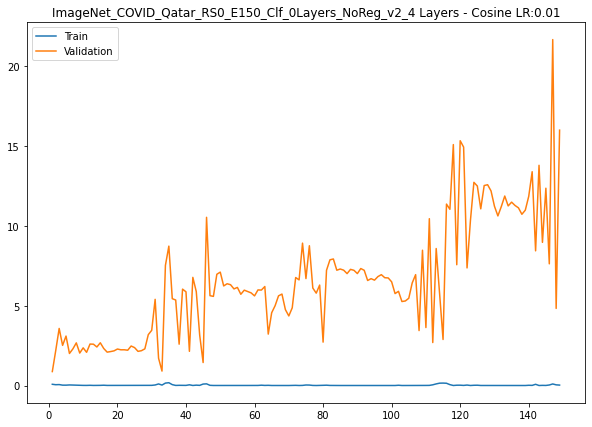

In [ ]:
plt.figure(figsize = (10,7))
lists = sorted(train_losses.items())
train_epoch, train_loss = zip(*lists[1:])
lists = sorted(val_losses.items())
val_epoch, val_loss = zip(*lists[1:])
plt.plot(train_epoch, train_loss, label = 'Train')
plt.plot(val_epoch, val_loss, label = 'Validation')
plt.title(MODEL_NAME+"_4 Layers - Cosine LR:"+str(LEARNING_RATE))
plt.legend()

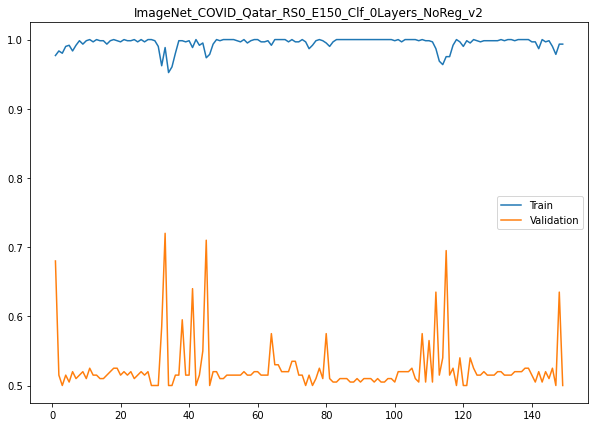

In [ ]:
plt.figure(figsize = (10,7))
lists = sorted(train_accs.items())
train_epoch, train_acc = zip(*lists[1:])
lists = sorted(val_accs.items())
val_epoch, val_acc = zip(*lists[1:])
plt.plot(train_epoch, train_acc, label = 'Train')
plt.plot(val_epoch, val_acc, label = 'Validation')
plt.title(MODEL_NAME)
plt.legend()

In [ ]:
def eval_model(model, criterion, eval_loader):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()
  loss_hist = {}
  model.eval()

  ## Tracking loss
  eval_loss = 0.0
  eval_accs = 0.0
  ## For Evaluation Data:
  for imgs, labels in eval_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)

      ## Zero the gradients
      optimizer.zero_grad()
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      eval_loss += loss.item() * imgs.size(0)
      eval_accs += torch.sum(preds == labels.data)

    
   

  eval_loss = eval_loss / len(eval_loader.dataset)
  eval_acc = eval_accs.double() / len(eval_loader.dataset)
  print("Loss: {:.4f}".format(eval_loss))
  print("Acc: {:.4f}".format(eval_acc))
  print("Time: {:.4f}".format(time.time() - start_time))

  return eval_loss, eval_acc

In [ ]:
eval_model(model_brixia, criterion, test_dl)

Loss: 1.6834
Acc: 0.5100
Time: 0.8593


(1.683434591293335, tensor(0.5100, device='cuda:0', dtype=torch.float64))

In [ ]:
eval_model(model_brixia, criterion, train_dl)

Loss: 0.0729
Acc: 0.9737
Time: 1.7284


(0.0729116185960409, tensor(0.9737, device='cuda:0', dtype=torch.float64))